In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from matplotlib import cm

<IPython.core.display.Javascript object>

In [3]:
def read_face_data_record(record: dict) -> dict:
    return {
        "is_face_detected": record["is_face_detected"],
        "angry": record["emotions"]["angry"],
        "disgust": record["emotions"]["disgust"],
        "fear": record["emotions"]["fear"],
        "happy": record["emotions"]["happy"],
        "sad": record["emotions"]["sad"],
        "neutral": record["emotions"]["neutral"],
        "head_turn": record["head_turn"],
        "eyes_closed": record["eyes_closed"],
    }

<IPython.core.display.Javascript object>

In [4]:
def get_signal_df_list(data_files: list) -> list:
    face_data_signals = []
    for data_file in data_files:
        with open(data_file) as f:
            face_data = pd.DataFrame(
                [read_face_data_record(json.loads(line)) for line in f]
            )
        face_data_signals.append(face_data)
    return face_data_signals

<IPython.core.display.Javascript object>

In [5]:
def merge_on_metric(
    face_data_signals: list,
    attr_name: str,
    column_names: list,
    smoothing_window: int,
    min_len: int,
) -> pd.DataFrame:
    res_df = (
        pd.DataFrame(
            [face_data[attr_name][:min_len] for face_data in face_data_signals],
        )
        .T.ewm(span=smoothing_window)
        .mean()
    )
    res_df.columns = column_names
    return res_df

<IPython.core.display.Javascript object>

In [24]:
data_files = [
    "uhmm_video_1.json",
    "uhmm_video_2.json",
    "uhmm_video_3.json",
    "uhmm_video_4.json",
    #     "face_data.json",
    "face_data2.json",
    #     "french_lesson.json",
    "fake_happy1.json",
    "fake_happy2.json",
    "fake_happy3.json",
]
data_files_dir = [os.path.join("../data", data_file) for data_file in data_files]
face_data_signals = get_signal_df_list(data_files_dir)

<IPython.core.display.Javascript object>

In [25]:
# min_len = min([face_data_signal.shape[0] for face_data_signal in face_data_signals])
# min_len

<IPython.core.display.Javascript object>

In [26]:
eyeblink_trashold = 3

<IPython.core.display.Javascript object>

In [27]:
# eye_blink_df = merge_on_metric(
#     face_data_signals=face_data_signals,
#     attr_name="eyes_closed",
#     column_names=data_files,
#     smoothing_window=1,
#     min_len=min_len,
# )
# eye_blink_df.head()

<IPython.core.display.Javascript object>

In [28]:
pd.DataFrame(
    [
        face_data_signal["eyes_closed"].describe()
        for face_data_signal in face_data_signals
    ],
    index=data_files,
)

,count,mean,std,min,25%,50%,75%,max
uhmm_video_1.json,4189.0,1.865541,0.418909,0.525584,1.713855,1.841213,1.978400,21.122777
uhmm_video_2.json,3956.0,1.840374,0.383640,0.555399,1.679886,1.803910,1.935873,15.013371
uhmm_video_3.json,3728.0,1.815537,0.435735,0.537465,1.630193,1.749034,1.894844,6.389741
uhmm_video_4.json,3794.0,1.800580,0.344374,0.448276,1.603040,1.768892,1.961716,5.584036
face_data2.json,8123.0,2.091903,0.398389,0.271645,1.919176,2.069611,2.217463,9.871633
fake_happy1.json,777.0,3.086787,1.965791,1.480005,2.208229,2.579178,3.229776,25.923290
fake_happy2.json,808.0,3.104091,1.579288,1.363646,2.287008,2.751563,3.419597,17.905040
fake_happy3.json,741.0,2.775952,1.311186,1.378999,2.008658,2.440789,3.163625,13.265874


<IPython.core.display.Javascript object>

In [31]:
eyeblink_distances = [
    pd.Series(
        face_data_signal.index[face_data_signal["eyes_closed"] > eyeblink_trashold]
    ).diff()
    for face_data_signal in face_data_signals
]

# eyeblink_distances = [
#     pd.Series(eye_blink_df.index[eye_blink_df[column] > eyeblink_trashold])
#     .diff()
#     .fillna(0)
#     for column in data_files
# ]
print([len(eyeblink_distance) for eyeblink_distance in eyeblink_distances])

[20, 38, 89, 31, 149, 246, 317, 215]


<IPython.core.display.Javascript object>

In [32]:
mean_std_df = pd.DataFrame(
    [
        (eyeblink_distance.mean(), eyeblink_distance.std())
        for eyeblink_distance in eyeblink_distances
    ],
    columns=["mean", "std"],
    index=data_files,
)
mean_std_df

,mean,std
uhmm_video_1.json,172.263158,282.994276
uhmm_video_2.json,88.945946,144.550058
uhmm_video_3.json,38.852273,160.905165
uhmm_video_4.json,127.166667,236.449905
face_data2.json,55.750000,154.100147
fake_happy1.json,3.134694,7.864257
fake_happy2.json,2.503165,5.960451
fake_happy3.json,3.434579,7.681019


<IPython.core.display.Javascript object>

<Axes: xlabel='mean', ylabel='std'>

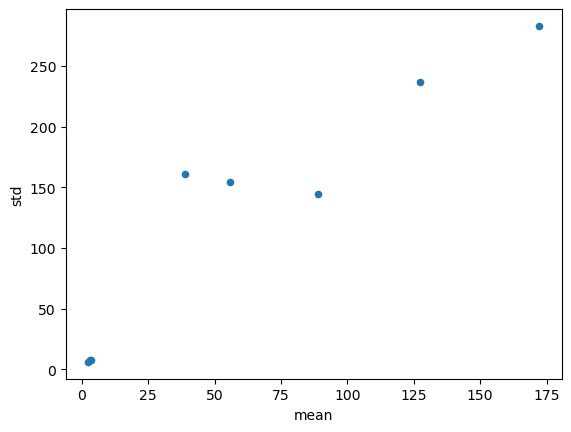

<IPython.core.display.Javascript object>

In [33]:
mean_std_df.plot(x="mean", y="std", kind="scatter")

/var/folders/sh/7hxrl8k913x6_bnwkr3k_m880000gn/T/ipykernel_65095/115188293.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")


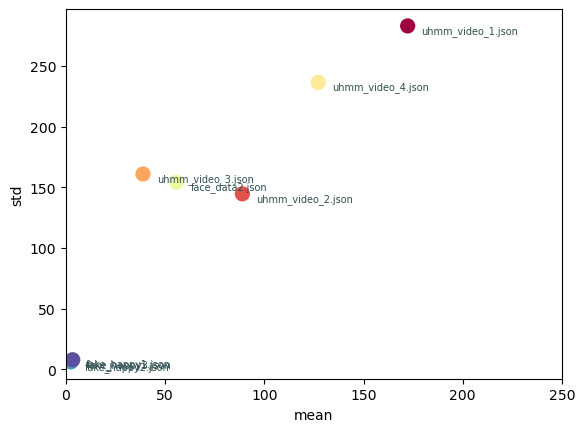

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots()
ax.set_xlim([0, 250])
# ax.set_ylim([0, 250])

cmap = cm.get_cmap("Spectral")
mean_std_df.plot(
    "mean",
    "std",
    kind="scatter",
    ax=ax,
    s=120,
    linewidth=0,
    c=range(len(mean_std_df)),
    colormap=cmap,
)

for k, v in mean_std_df.iterrows():
    ax.annotate(
        k,
        v,
        xytext=(10, -5),
        textcoords="offset points",
        family="sans-serif",
        fontsize=7,
        color="darkslategrey",
    )